In [5]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# **Part I. Data Wrangling**


In [8]:
# read dataset
ds = pd.read_csv('/dataset/customer_review.tsv', sep='\t')
# print first 10
print(ds.head(10))
# check for missing values
print(ds.isnull().sum())

   rating       date             variation  \
0       5  31-Jul-18      Charcoal Fabric    
1       5  31-Jul-18      Charcoal Fabric    
2       4  31-Jul-18        Walnut Finish    
3       5  31-Jul-18      Charcoal Fabric    
4       5  31-Jul-18      Charcoal Fabric    
5       5  31-Jul-18  Heather Gray Fabric    
6       3  31-Jul-18     Sandstone Fabric    
7       5  31-Jul-18      Charcoal Fabric    
8       5  30-Jul-18  Heather Gray Fabric    
9       5  30-Jul-18  Heather Gray Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
5  I received the echo as a gift. I needed anothe...         1  
6  Without having a cellphone, I canno

In [9]:
# remove stop words
nltk.download('stopwords')
stop = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(data):
  data['review_clean'] = data['verified_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  return data

# remove stopwords from dataset
ds_clean = remove_stopwords(ds)
ds_clean.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,rating,date,variation,verified_reviews,feedback,review_clean
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Love Echo!
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Loved it!
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,"Sometimes playing game, answer question correc..."
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,"I lot fun thing. My 4 yr old learns dinosaurs,..."
4,5,31-Jul-18,Charcoal Fabric,Music,1,Music


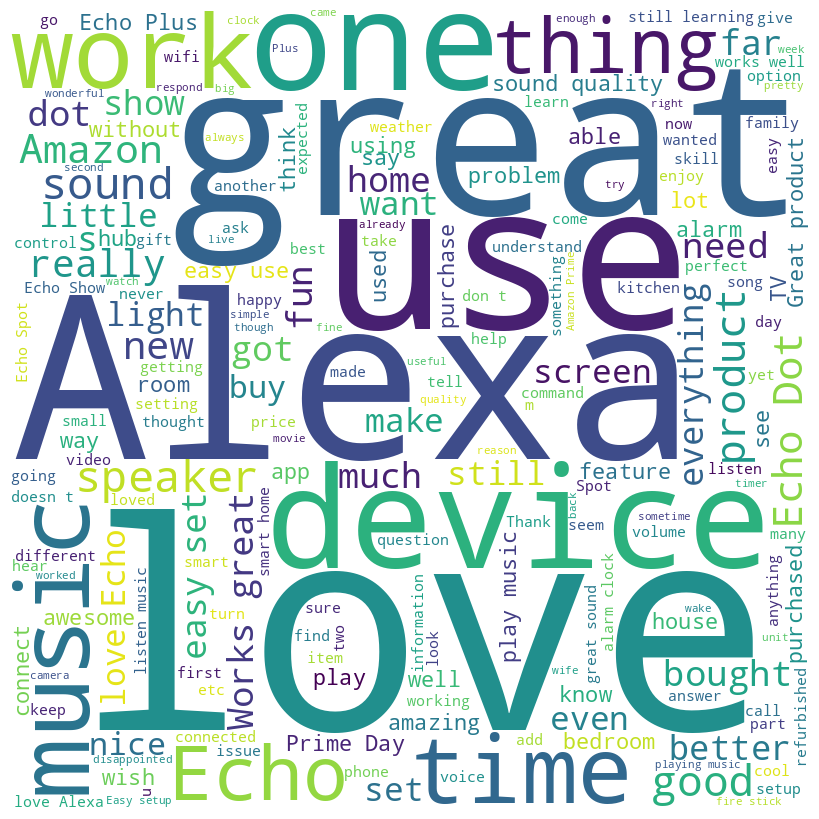

In [10]:
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(ds_clean['review_clean']))
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# **Part. II Data Engineering**

In [2]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

In [12]:
# target labels
labelEncoder = LabelEncoder()
ds_clean['feedback_encoded'] = labelEncoder.fit_transform(ds_clean['feedback'])

In [13]:
# convert into vectors
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(ds_clean['review_clean'])
X = tokenizer.texts_to_sequences(ds_clean['review_clean'])

# **Part. III Model Design**

In [17]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

In [23]:
from keras.preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X, maxlen=60)
input_length = X_padded.shape[1]

In [25]:
# LSTM Model
model = Sequential()
model.add(Embedding(5000, 120, input_length=input_length))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 120)           600000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 60, 120)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 176)               209088    
                                                                 
 dense_1 (Dense)             (None, 2)                 354       
                                                                 
Total params: 809442 (3.09 MB)
Trainable params: 809442 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Part IV. Data Splitting**

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [31]:
Y = to_categorical(ds_clean['feedback_encoded'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# **Part V. Training the Model**

In [35]:
X_train_padded = pad_sequences(X_train, maxlen=60)
X_test_padded = pad_sequences(X_test, maxlen=60)

X_train_array = np.array(X_train_padded)
X_test_array = np.array(X_test_padded)


In [36]:
model.fit(X_train_array, Y_train, epochs=5, batch_size=32, verbose='auto')

Epoch 1/5
79/79 [==============================] - 22s 232ms/step - loss: 0.3010 - accuracy: 0.9159
Epoch 2/5
79/79 [==============================] - 20s 252ms/step - loss: 0.1872 - accuracy: 0.9313
Epoch 3/5
79/79 [==============================] - 19s 233ms/step - loss: 0.1169 - accuracy: 0.9611
Epoch 4/5
79/79 [==============================] - 18s 231ms/step - loss: 0.0641 - accuracy: 0.9786
Epoch 5/5
79/79 [==============================] - 20s 258ms/step - loss: 0.0369 - accuracy: 0.9893


# **Part VI. Evaluate the Model**

In [37]:
from sklearn.metrics import classification_report

In [38]:
predictions = model.predict(X_test_array)
predicted_labels = np.argmax(predictions, axis=1)


20/20 [==============================] - 2s 54ms/step


In [39]:
true_labels = np.argmax(Y_test, axis=1)
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.69      0.57      0.62        58
           1       0.96      0.97      0.97       572

    accuracy                           0.94       630
   macro avg       0.82      0.77      0.79       630
weighted avg       0.93      0.94      0.93       630

